In [70]:
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [2]:
df_states = gpd.read_file('Data/us-states.json')
df_fires = gpd.read_file('Data/mtbs_fire_locations.geojson')

In [ ]:
df_states

In [3]:
df_western_us = df_states[df_states['name'].isin(['California', 'Oregon', 'Washington', 'Nevada', 'Arizona', 'Idaho', 'Montana', 'Utah', 'Wyoming', 'Colorado', 'New Mexico'])]

<AxesSubplot:>

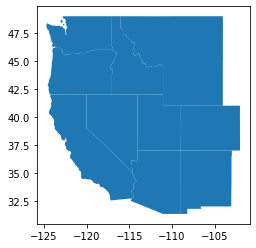

In [4]:
df_western_us.plot()

In [ ]:
gpd.GeoDataFrame(df_western_us).to_file('Data/western_us.geojson', driver='GeoJSON')

In [4]:
df_fires["Ig_Date"] = pd.to_datetime(df_fires["Ig_Date"])

In [5]:
df_fires["year"] = df_fires["Ig_Date"].dt.year

In [18]:
def timestamp_to_year_part(df):
    date = df["Ig_Date"][0]
    year = int(date.strftime("%Y"))
    print('{} / {}'.format(date,year))
    df.year.values[:] = year
    return df

In [125]:
# date_mask_1985 = (df_fires["Ig_Date"] >= '1985-01-01') & (df_fires["Ig_Date"] <= '1985-12-31')
# date_mask_2015 = (df_fires["Ig_Date"] >= '2015-01-01') & (df_fires["Ig_Date"] <= '2015-12-31')
fire_date_mask = (df_fires["Ig_Date"] >= '1985-01-01') & (df_fires["Ig_Date"] <= '2020-12-31')
fire_type_mask = (df_fires["Incid_Type"] != 'Prescribed Fire')
fire_size_mask = (df_fires["BurnBndAc"] >= 5000)
fire_location_mask = (df_fires["geometry"].within(df_western_us.unary_union))

In [126]:
# fires_1985 = df_fires[date_mask_1985 & fire_type_mask & fire_size_mask & fire_location_mask]
# fires_2015 = df_fires[date_mask_2015 & fire_type_mask & fire_size_mask & fire_location_mask]
western_fires = df_fires[fire_type_mask & fire_location_mask & fire_date_mask & fire_size_mask]

In [ ]:
df_fires.assign(year=np.int32(0))
df_fires = df_fires.apply(timestamp_to_year_part, axis=1)

In [14]:
def extract_state(df):
    df["State"] = df["Event_ID"].apply(lambda x: x[0:2])
    return df

In [50]:
gpd.GeoDataFrame(western_fires).to_file('Data/western_fires.geojson', driver='GeoJSON')

/home/jake/miniconda3/envs/rstools/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [127]:
western_fires = extract_state(western_fires)

/home/jake/miniconda3/envs/rstools/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
states = {
    "AZ": "Arizona",
    "CA": "California",
    "CO": "Colorado",
    "ID": "Idaho",
    "MT": "Montana",
    "NV": "Nevada",
    "NM": "New Mexico",
    "OR": "Oregon",
    "UT": "Utah",
    "WA": "Washington",
    "WY": "Wyoming"
}

In [128]:
western_fires["State"] = western_fires["State"].apply(lambda x: states[x])

In [101]:
burned_area_per_year_per_state = pd.DataFrame(western_fires.groupby(["State", "year"])["BurnBndAc"].sum())

In [129]:
burned_area_per_year = pd.DataFrame(western_fires.groupby(["year"])["BurnBndAc"].sum())

In [131]:
burned_area_per_year.to_csv('Data/burned_area_per_year.csv')

In [102]:
burned_area_per_year_per_state = burned_area_per_year_per_state.sort_values(by="BurnBndAc", ascending=False)

In [103]:
burned_area_per_year_per_state

BurnBndAc
State      year           
California 2020    4528714
Idaho      2007    2157768
           2012    1719025
Nevada     1999    1659858
Wyoming    1988    1510922
...                    ...
Arizona    1991       5590
Idaho      2021       5562
Washington 1989       5442
Utah       2014       5373
           2008       5178

[355 rows x 1 columns]

In [110]:
burned_area_per_year_per_state.to_csv("Data/burned_area_per_year_per_state.csv")

In [113]:
burned_area_per_year_per_state

BurnBndAc
State      year           
California 2020    4528714
Idaho      2007    2157768
           2012    1719025
Nevada     1999    1659858
Wyoming    1988    1510922
...                    ...
Arizona    1991       5590
Idaho      2021       5562
Washington 1989       5442
Utah       2014       5373
           2008       5178

[355 rows x 1 columns]

In [124]:
px.histogram(western_fires["BurnBndAc"], nbins=1000, title="Histogram of Burned Area")